In [26]:
import pandas as pd
import datetime
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [27]:
table = pd.read_csv("final_data.csv")
table

,state,Date,State,Region,Division,Daily_Death,Daily_Case,Above_Poverty_Level_Population,No_Health_Insurance_Population,population,...,Bachelors_Degree_or_Higher_Population,Fully_reopen,Mask_Mandate,Vaccination_or_test,Ratio of people per hospital employee,Ratio of people per hospital,gdp_2020,employed_population,People_Fully_Vaccinated,tests_combined_total
0,AL,2021-07-17,Alabama,South,East South Central,1,901,3958299,457826,4903185,...,845772,1,0,0,50,20689,899481,2150858,1648172,4839086
1,AL,2021-07-18,Alabama,South,East South Central,0,724,3958299,457826,4903185,...,845772,1,0,0,50,20689,899481,2150858,1651404,4842269
2,AL,2021-07-19,Alabama,South,East South Central,0,718,3958299,457826,4903185,...,845772,1,0,0,50,20689,899481,2150858,1653604,4849123
3,AL,2021-07-20,Alabama,South,East South Central,17,1391,3958299,457826,4903185,...,845772,1,0,0,50,20689,899481,2150858,1654644,4857505
4,AL,2021-07-21,Alabama,South,East South Central,2,1632,3958299,457826,4903185,...,845772,1,0,0,50,20689,899481,2150858,1659775,4865573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,WY,2021-10-07,Wyoming,West,Mountain,0,681,504661,65354,578759,...,106855,1,0,0,47,18086,144966,283956,244243,1006222
4433,WY,2021-10-08,Wyoming,West,Mountain,0,539,504661,65354,578759,...,106855,1,0,0,47,18086,144966,283956,244957,1006222
4434,WY,2021-10-09,Wyoming,West,Mountain,0,0,504661,65354,578759,...,106855,1,0,0,47,18086,144966,283956,245545,1006222
4435,WY,2021-10-10,Wyoming,West,Mountain,0,0,504661,65354,578759,...,106855,1,0,0,47,18086,144966,283956,245545,1006222


In [28]:
table = table.drop(["State"], 1)

In [29]:
# format
format = '%Y-%m-%d'
Da = []
for index, row in table.iterrows():
    #print(row['c1'], row['c2'])
    Da.append(datetime.datetime.strptime(row["Date"], format).date())
table["Date"] = Da

In [30]:
split_date = datetime.date(2021,9,1)
table_train = table.loc[table["Date"]<split_date].copy()
table_test = table.loc[table["Date"]>=split_date].copy()

In [31]:
# format
D = []
for index, row in table_train.iterrows():
    #print(row['c1'], row['c2'])
    D.append(str(row["Date"]))
table_train["Date"] = D

In [32]:
# format
D = []
for index, row in table_test.iterrows():
    #print(row['c1'], row['c2'])
    D.append(str(row["Date"]))
table_test["Date"] = D

In [33]:
Year = []
Month = []
Day = []
for index, row in table_train.iterrows():
    #print(row['c1'], row['c2'])
    Year.append(int(row["Date"].split("-")[0]))
    Month.append(int(row["Date"].split("-")[1]))
    Day.append(int(row["Date"].split("-")[2]))

table_train["Year"] = Year
table_train["Month"] = Month
table_train["Day"] = Day

table_train = table_train.drop("Date", 1)

In [34]:
Year = []
Month = []
Day = []
for index, row in table_test.iterrows():
    #print(row['c1'], row['c2'])
    Year.append(int(row["Date"].split("-")[0]))
    Month.append(int(row["Date"].split("-")[1]))
    Day.append(int(row["Date"].split("-")[2]))

table_test["Year"] = Year
table_test["Month"] = Month
table_test["Day"] = Day

table_test = table_test.drop("Date", 1)

In [35]:
table_train = pd.get_dummies(table_train)
table_test = pd.get_dummies(table_test)

In [11]:
y_train = table_train["Daily_Case"]
X_train = table_train.drop(["Daily_Case","Daily_Death"],1)
y_test = table_test["Daily_Case"]
X_test = table_test.drop(["Daily_Case","Daily_Death"],1)

In [12]:
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=500,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

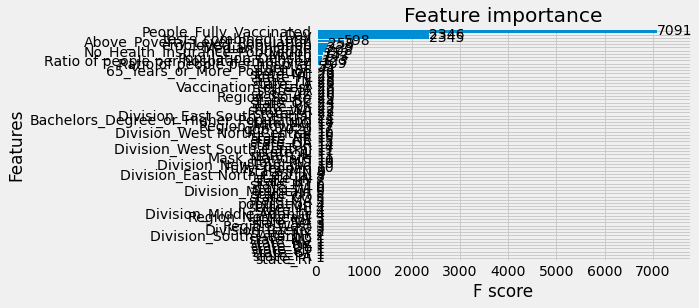

In [13]:
_ = plot_importance(reg, height=0.9)

In [14]:
table_test["Case_Prediction"] = reg.predict(X_test)

In [15]:
table_all = pd.concat([table_test, table_train], sort=False)

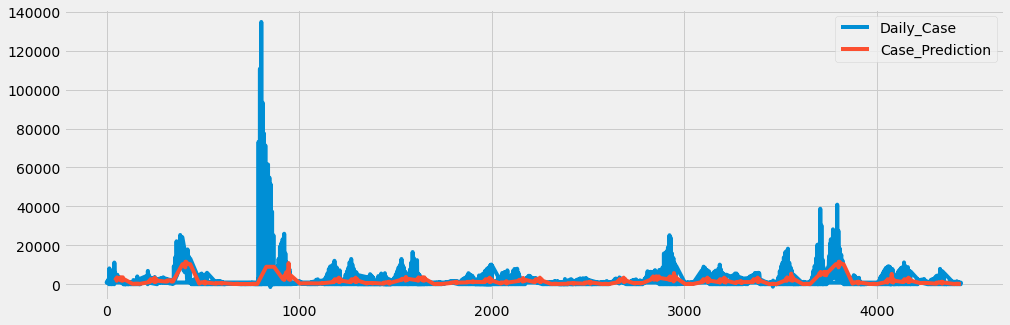

In [16]:
_ = table_all[['Daily_Case','Case_Prediction']].plot(figsize=(15, 5))

In [17]:
mean_squared_error(y_true=table_test['Daily_Case'],
                   y_pred=table_test['Case_Prediction'])

14199336.844162855

In [ ]:
# death 

In [36]:
y_train_death = table_train["Daily_Death"]
X_train_death = table_train.drop(["Daily_Case","Daily_Death"],1)
y_test_death = table_test["Daily_Death"]
X_test_death = table_test.drop(["Daily_Case","Daily_Death"],1)

In [37]:
reg_death = xgb.XGBRegressor(n_estimators=10000)


In [38]:
reg_death.fit(X_train_death, y_train_death,
        eval_set=[(X_train_death, y_train_death), (X_test_death, y_test_death)],
        early_stopping_rounds=500, verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

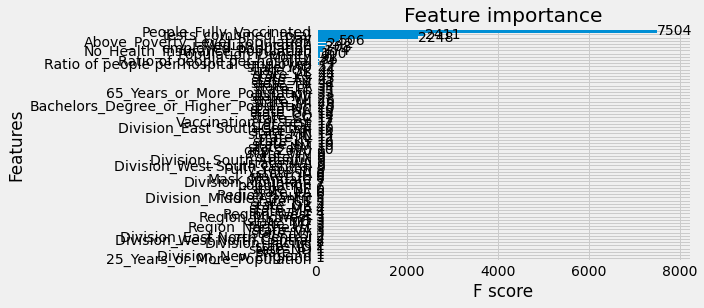

In [39]:
_ = plot_importance(reg_death, height=0.9)

In [44]:
table_test["Death_Prediction"] = reg_death.predict(X_test_death)

In [45]:
table_all = pd.concat([table_test, table_train], sort=False)

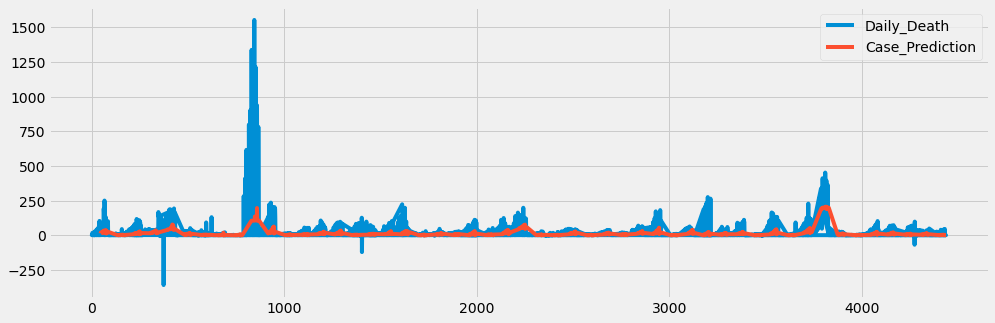

In [46]:
_ = table_all[['Daily_Death','Case_Prediction']].plot(figsize=(15, 5))

In [47]:
mean_squared_error(y_true=table_test['Daily_Case'],
                   y_pred=table_test['Case_Prediction'])

24559190.43331172